In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
from xgboost import XGBRegressor


SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [5]:
DATA_CSV = "hourly_data_p_s1.csv"

MODEL_DIR = "xgb_models_ps1"
SCALER_DIR = "xgb_scalers_ps1"
PLOTS_DIR = "xgb_plots_ps1"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(SCALER_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)


N_STEPS = 24
LAST_N_HOURS_TO_PLOT = 200


In [6]:
def create_sequences(values, n_steps=24):
    X, y = [], []
    for i in range(len(values) - n_steps):
        X.append(values[i:i+n_steps])
        y.append(values[i+n_steps])
    return np.array(X), np.array(y)

In [7]:
df = pd.read_csv(DATA_CSV, parse_dates=['localminute'])
df = df.sort_values('localminute').reset_index(drop=True)

house_ids = df['dataid'].unique()
print("Total houses found:", len(house_ids))
results = []

Total houses found: 14



Training XGBoost for House 26
Training samples: 2288
Testing samples: 572
Saved model for house: 26
MAE = 0.4111 | RMSE = 0.6914


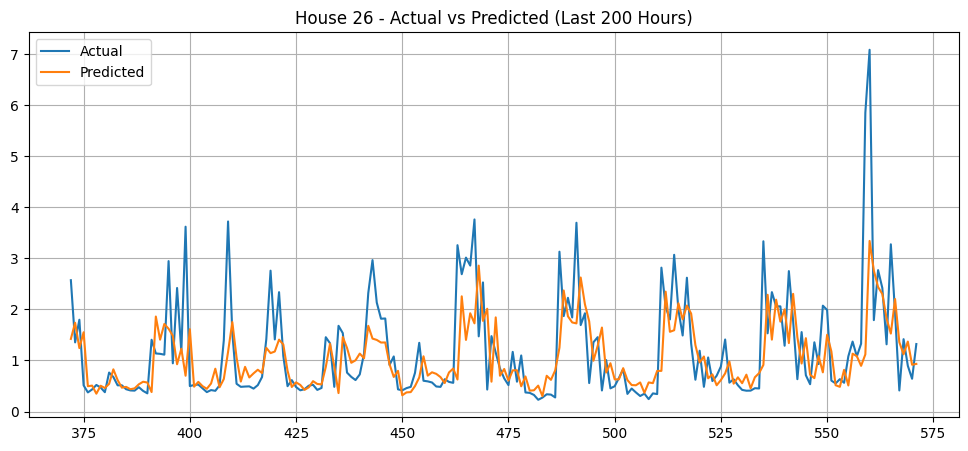

Saved plot: xgb_plots_ps1/house_26_last200.png

Training XGBoost for House 222
Training samples: 2286
Testing samples: 572
Saved model for house: 222
MAE = 1.0262 | RMSE = 1.4357


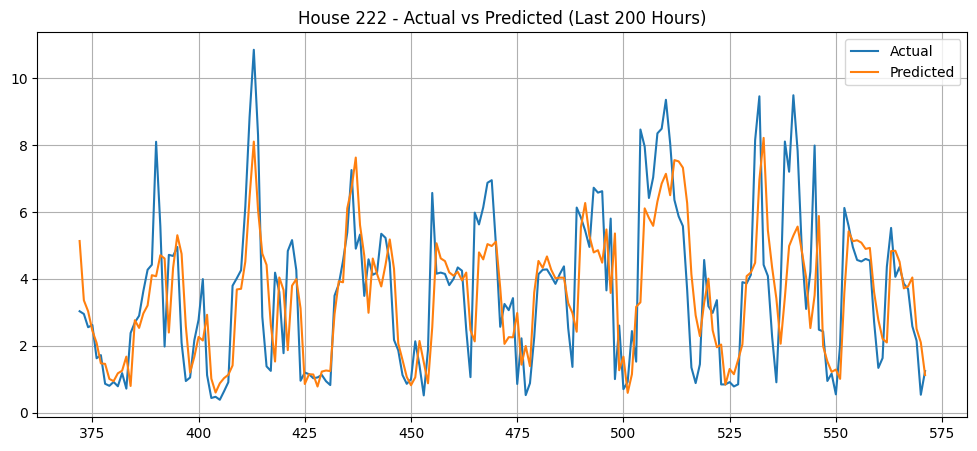

Saved plot: xgb_plots_ps1/house_222_last200.png

Training XGBoost for House 187
Training samples: 2286
Testing samples: 572
Saved model for house: 187
MAE = 0.5416 | RMSE = 0.8024


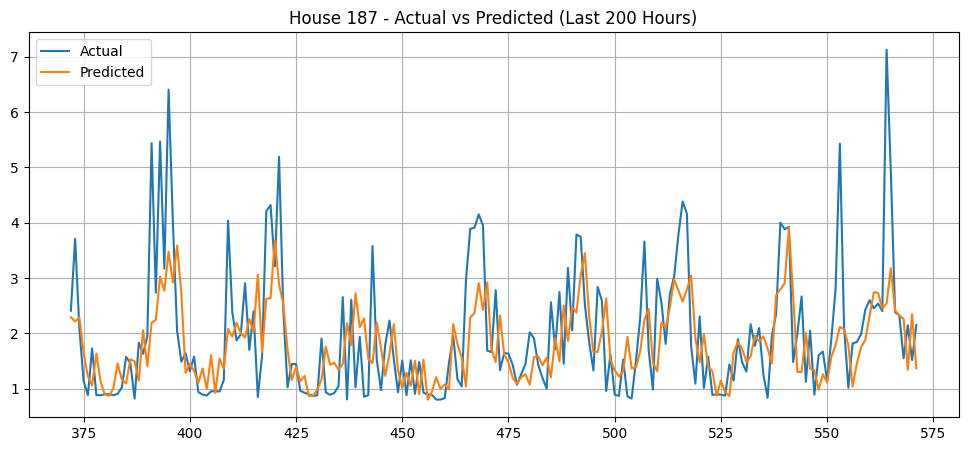

Saved plot: xgb_plots_ps1/house_187_last200.png

Training XGBoost for House 171
Training samples: 2288
Testing samples: 573
Saved model for house: 171
MAE = 0.2159 | RMSE = 0.3531


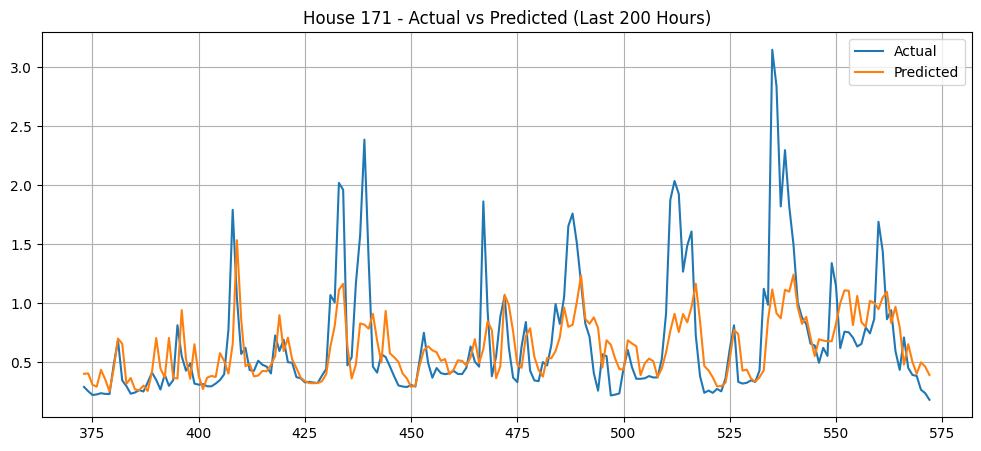

Saved plot: xgb_plots_ps1/house_171_last200.png

Training XGBoost for House 370
Training samples: 2287
Testing samples: 572
Saved model for house: 370
MAE = 0.5672 | RMSE = 0.8958


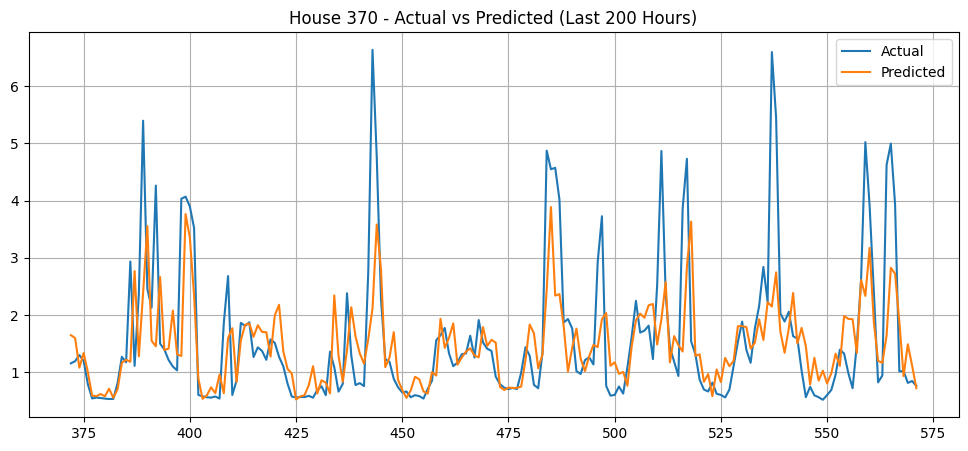

Saved plot: xgb_plots_ps1/house_370_last200.png

Training XGBoost for House 115
Training samples: 2286
Testing samples: 572
Saved model for house: 115
MAE = 0.1787 | RMSE = 0.2669


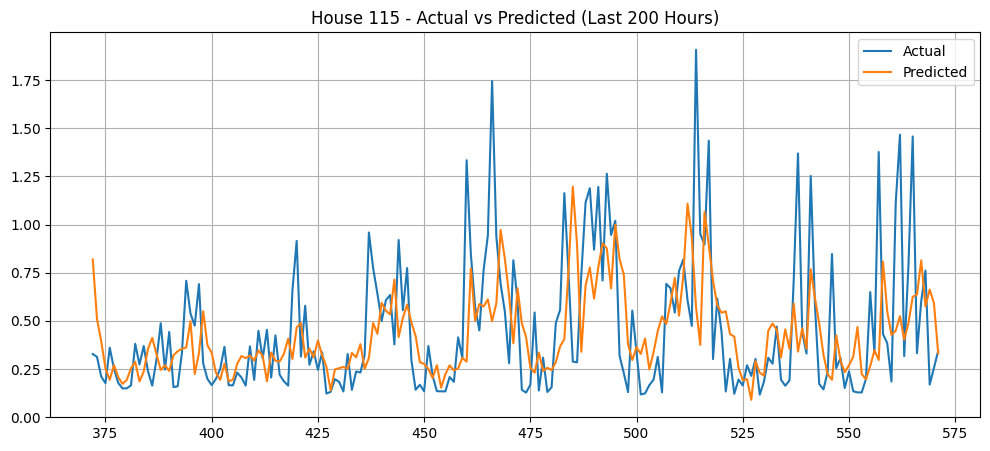

Saved plot: xgb_plots_ps1/house_115_last200.png

Training XGBoost for House 114
Training samples: 2287
Testing samples: 572
Saved model for house: 114
MAE = 0.3534 | RMSE = 0.5712


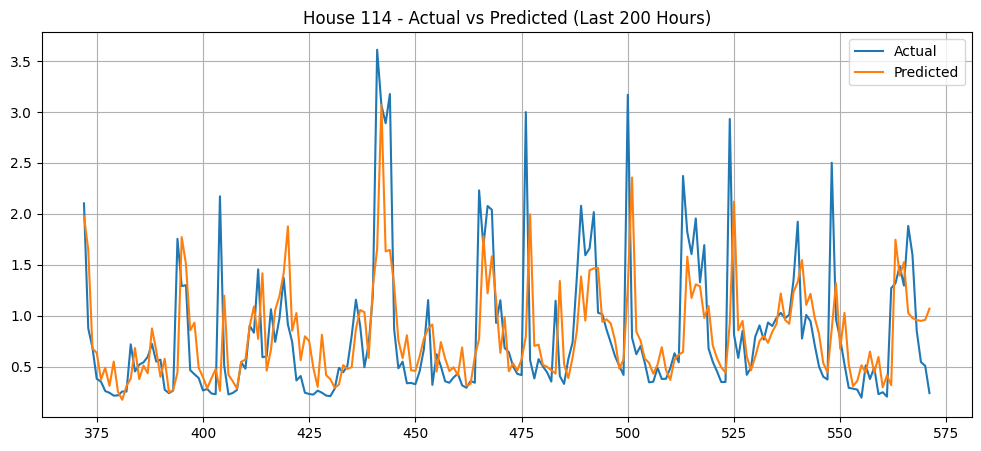

Saved plot: xgb_plots_ps1/house_114_last200.png

Training XGBoost for House 101
Training samples: 2288
Testing samples: 573
Saved model for house: 101
MAE = 0.2398 | RMSE = 0.5205


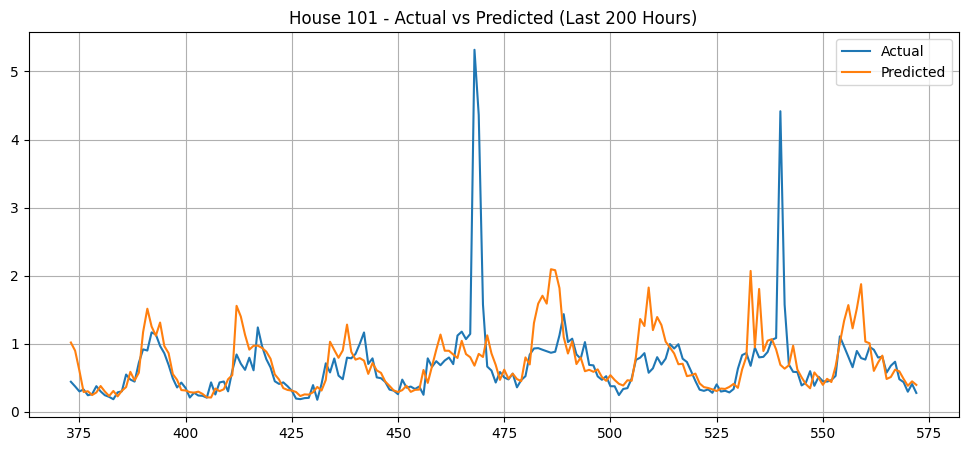

Saved plot: xgb_plots_ps1/house_101_last200.png

Training XGBoost for House 93
Training samples: 2286
Testing samples: 572
Saved model for house: 93
MAE = 0.3037 | RMSE = 0.5601


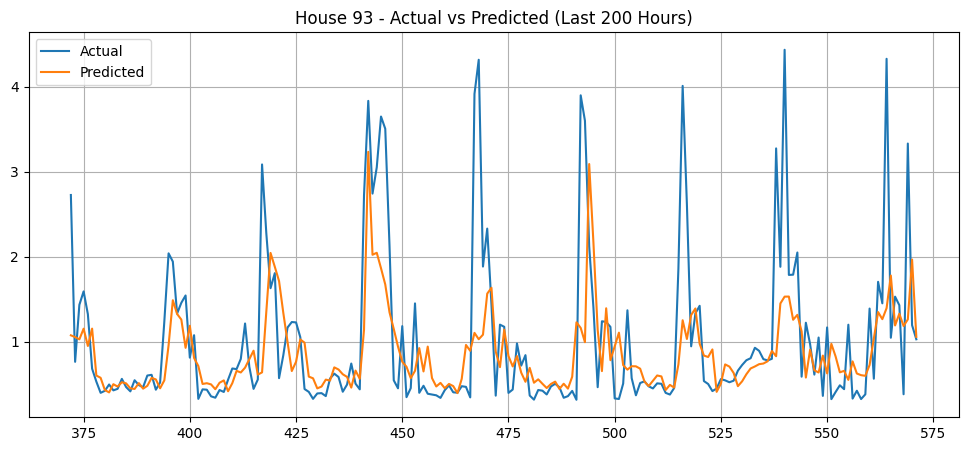

Saved plot: xgb_plots_ps1/house_93_last200.png

Training XGBoost for House 379
Training samples: 2287
Testing samples: 572
Saved model for house: 379
MAE = 0.5415 | RMSE = 0.9939


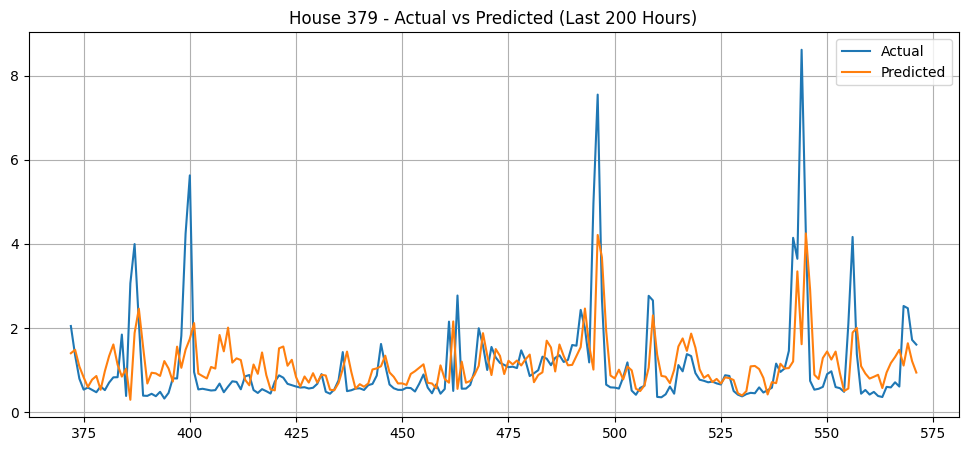

Saved plot: xgb_plots_ps1/house_379_last200.png

Training XGBoost for House 86
Training samples: 2288
Testing samples: 573
Saved model for house: 86
MAE = 0.3736 | RMSE = 0.6960


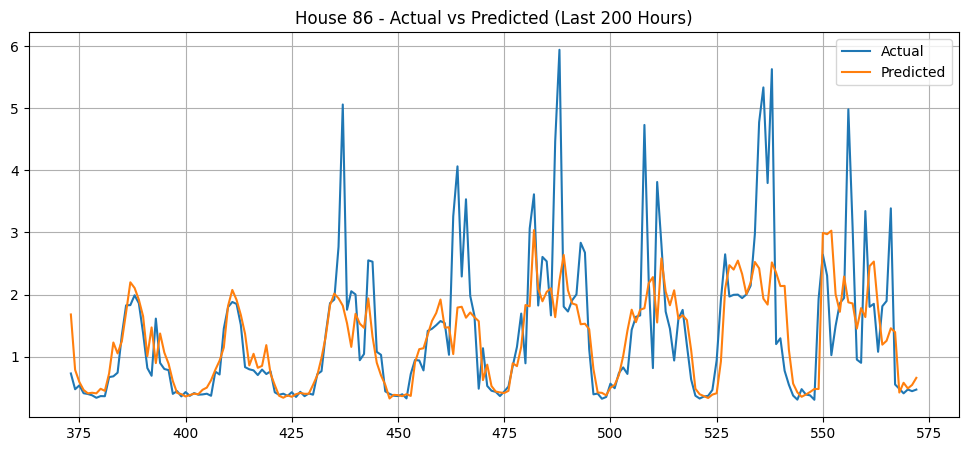

Saved plot: xgb_plots_ps1/house_86_last200.png

Training XGBoost for House 77
Training samples: 2287
Testing samples: 572
Saved model for house: 77
MAE = 0.3319 | RMSE = 0.5235


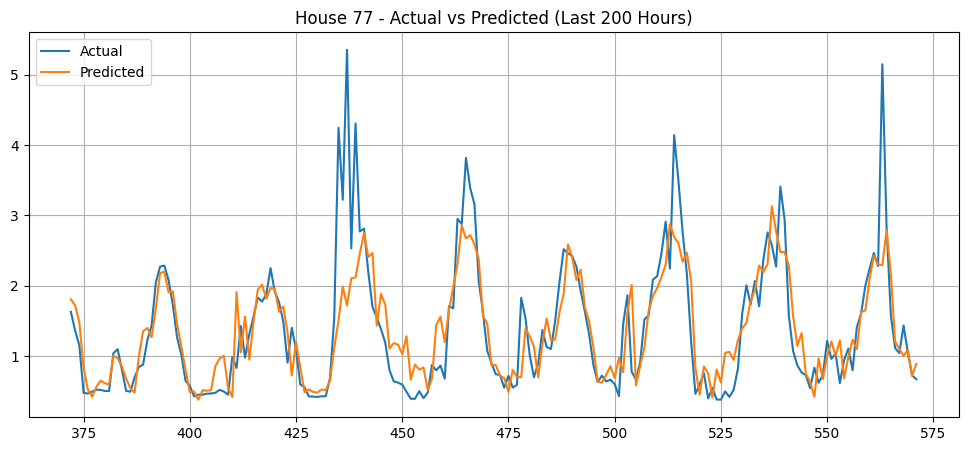

Saved plot: xgb_plots_ps1/house_77_last200.png

Training XGBoost for House 59
Training samples: 2287
Testing samples: 572
Saved model for house: 59
MAE = 0.2648 | RMSE = 0.4926


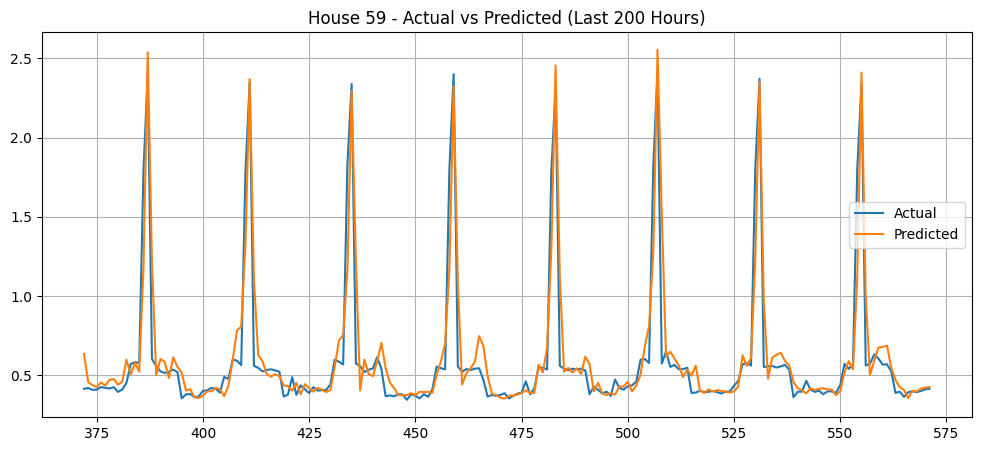

Saved plot: xgb_plots_ps1/house_59_last200.png

Training XGBoost for House 252
Training samples: 2287
Testing samples: 572
Saved model for house: 252
MAE = 0.5317 | RMSE = 0.8358


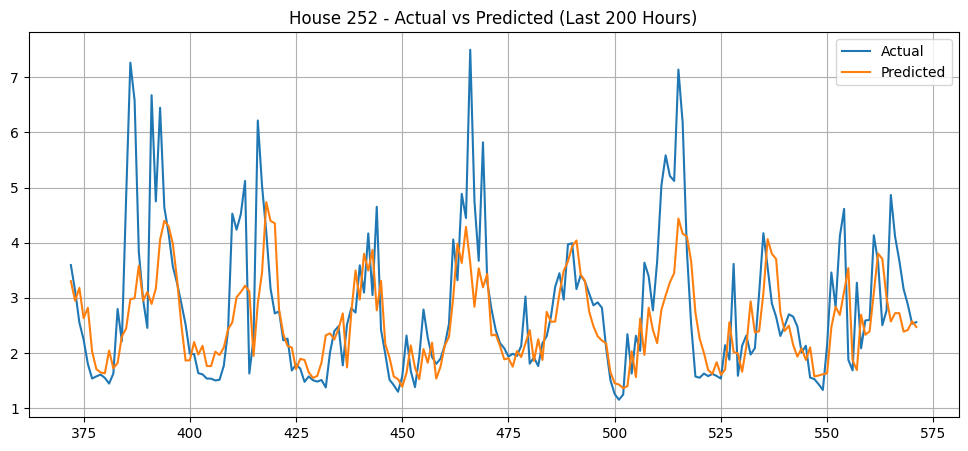

Saved plot: xgb_plots_ps1/house_252_last200.png
Saved metrics file: house_wise_xgb_metrics.csv


In [8]:
for hid in house_ids:

    print("\n" + "="*60)
    print(f"Training XGBoost for House {hid}")

    house_df = df[df['dataid'] == hid].copy()
    house_df = house_df.sort_values('localminute')
    house_df = house_df[['localminute', 'use']].dropna()

    if len(house_df) < N_STEPS + 10:
        print(f"Skipping House {hid}: Not enough data")
        continue

    values = house_df['use'].values.reshape(-1,1)

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)

    joblib.dump(scaler, f"{SCALER_DIR}/scaler_{hid}.joblib")

    
    X, y = create_sequences(scaled, N_STEPS)

    # Flatten X → (samples, 24)
    X = X.reshape(X.shape[0], X.shape[1])

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    print("Training samples:", len(X_train))
    print("Testing samples:", len(X_test))

    
    model = XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=SEED
    )

    model.fit(X_train, y_train)

   
    joblib.dump(model, f"{MODEL_DIR}/xgb_house_{hid}.joblib")
    print("Saved model for house:", hid)

    # -----------------------
    # Predict
    # -----------------------
    preds_scaled = model.predict(X_test).reshape(-1,1)
    y_test_scaled = y_test.reshape(-1,1)

    preds = scaler.inverse_transform(preds_scaled)
    y_true = scaler.inverse_transform(y_test_scaled)

    # -----------------------
    # Metrics
    # -----------------------
    mae = mean_absolute_error(y_true, preds)
    rmse = np.sqrt(mean_squared_error(y_true, preds))

    print(f"MAE = {mae:.4f} | RMSE = {rmse:.4f}")

    results.append([hid, round(mae,4), round(rmse,4)])

    # -----------------------
    # Plot last 200 hours
    # -----------------------
    start_idx = split + N_STEPS
    time_index = house_df['localminute'].iloc[
        start_idx : start_idx + len(y_true)
    ].reset_index(drop=True)

    df_plot = pd.DataFrame({
        "time": time_index,
        "actual": y_true.flatten(),
        "predicted": preds.flatten()
    })

    df_last = df_plot.tail(LAST_N_HOURS_TO_PLOT)

    plt.figure(figsize=(12,5))
    plt.plot(df_last['actual'], label="Actual")
    plt.plot(df_last['predicted'], label="Predicted")
    plt.title(f"House {hid} - Actual vs Predicted (Last 200 Hours)")
    plt.legend()
    plt.grid()

    plot_path = f"{PLOTS_DIR}/house_{hid}_last200.png"
    plt.savefig(plot_path, dpi=150)
    plt.show()

    print(f"Saved plot: {plot_path}")


results_df = pd.DataFrame(results, columns=["house_id", "mae", "rmse"])
results_df.to_csv("house_wise_xgb_metrics.csv", index=False)

print("Saved metrics file: house_wise_xgb_metrics.csv")

In [9]:
import pandas as pd
import numpy as np
import joblib
import os

def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len].flatten())
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

df = pd.read_csv("hourly_data_p_s1.csv", parse_dates=["localminute"])
df = df.sort_values("localminute")

statistical_rows = []

for house_id in df["dataid"].unique():

    model_path  = f"xgb_models_ps1/xgb_house_{house_id}.joblib"
    scaler_path = f"xgb_scalers_ps1/scaler_{house_id}.joblib"

    if not os.path.exists(model_path):
        print(f"Skipping house {house_id} (model not found)")
        continue

    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    temp = df[df["dataid"] == house_id][["use"]].dropna()

    scaled = scaler.transform(temp.values)

    X, y = create_sequences(scaled, 24)

    y_pred = model.predict(X).reshape(-1,1)

    y_true = scaler.inverse_transform(y)
    y_pred = scaler.inverse_transform(y_pred)

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    
    statistical_rows.append([
        house_id,

        np.mean(y_true),
        np.mean(y_pred),

        np.std(y_true),
        np.std(y_pred),

        np.min(y_true),
        np.min(y_pred),

        np.max(y_true),
        np.max(y_pred),

        np.median(y_true),
        np.median(y_pred),

        pd.Series(y_true).corr(pd.Series(y_pred)),

        np.var(y_true),
        np.var(y_pred),

        np.max(y_true) - np.min(y_true),
        np.max(y_pred) - np.min(y_pred)
    ])


df_stats2 = pd.DataFrame(
    statistical_rows,
    columns=[
        "House",
        "Actual Mean", "Pred Mean",
        "Actual STD", "Pred STD",
        "Actual Min", "Pred Min",
        "Actual Max", "Pred Max",
        "Actual Median", "Pred Median",
        "Correlation (True vs Pred)",
        "Actual Variance", "Pred Variance",
        "Actual Range", "Pred Range"
    ]
)


# Save CSV

df_stats2.to_csv("xgb_actual_vs_predicted_statistics_ps1.csv", index=False)

print("Statistics file saved as xgb_actual_vs_predicted_statistics_ps1.csv")



Statistics file saved as xgb_actual_vs_predicted_statistics_ps1.csv


In [11]:
import pandas as pd
import numpy as np
import joblib
import os



def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len].flatten())   # FLATTEN
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)


df = pd.read_csv("hourly_data_p_s1.csv", parse_dates=["localminute"])
df = df.sort_values("localminute")

hour_rows = []


for house_id in df["dataid"].unique():

    model_path  = f"xgb_models_ps1/xgb_house_{house_id}.joblib"
    scaler_path = f"xgb_scalers_ps1/scaler_{house_id}.joblib"

    if not os.path.exists(model_path):
        print(f"Skipping house {house_id} (model missing)")
        continue

    print(f"Processing hour-level stats for House {house_id}...")

    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    temp = df[df["dataid"] == house_id][["use"]].dropna()

  
    scaled = scaler.transform(temp.values)

    
    X, y = create_sequences(scaled, 24)

   
    y_pred = model.predict(X).reshape(-1,1)

    
    y_true = scaler.inverse_transform(y)
    y_pred = scaler.inverse_transform(y_pred)

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    for idx in range(len(y_true)):
        actual = y_true[idx]
        predicted = y_pred[idx]
        error = predicted - actual

        hour_rows.append([
            house_id,
            idx,
            actual,
            predicted,
            error,
            abs(error),
            error**2,
            (abs(error) / actual * 100) if actual != 0 else np.nan
        ])


df_hour_stats = pd.DataFrame(
    hour_rows,
    columns=[
        "House",
        "HourIndex",
        "Actual",
        "Predicted",
        "Error",
        "AbsoluteError",
        "SquaredError",
        "PercentageError"
    ]
)


df_hour_stats.to_csv("xgb_hour_level_stats_ps1.csv", index=False)

print("Hour-level statistics saved as xgb_hour_level_stats_ps1.csv")



Processing hour-level stats for House 26...
Processing hour-level stats for House 222...
Processing hour-level stats for House 187...
Processing hour-level stats for House 171...
Processing hour-level stats for House 370...
Processing hour-level stats for House 115...
Processing hour-level stats for House 114...
Processing hour-level stats for House 101...
Processing hour-level stats for House 93...
Processing hour-level stats for House 379...
Processing hour-level stats for House 86...
Processing hour-level stats for House 77...
Processing hour-level stats for House 59...
Processing hour-level stats for House 252...
Hour-level statistics saved as xgb_hour_level_stats_ps1.csv
